# Cleaning and Basic Feature Extraction

In this notebook we aim to do some basic cleaning of the data and extract musically informed features that are human understandable.

First we load in the various dependencies that will be used in this notebook.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display

import IPython.display
import scipy

Dataset explored is UrbanSound8K:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

https://urbansounddataset.weebly.com/urbansound8k.html

https://zenodo.org/record/1203745

First things first, we should load in the provided metadata and write a few convienience functions for getting the .wav files based on the provided metadata.

In [2]:
# Data should be placed in the "large_data/" directory, which is not staged in the git repo
metadata = pd.read_csv('./large_data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.info()
display(metadata)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [3]:
# Function to load wav file with librosa, given a row from metadata table
def load_data(meta_row):
    filename = meta_row['slice_file_name']
    filepath = f'large_data/UrbanSound8K/audio/fold{meta_row["fold"]}/'
    return librosa.load(filepath+filename,sr=None)

The various audiofiles do not exhibit a uniform length or sampling rate. As such we aim to do some pre-classification analysis to generate a uniform observable vector.

For this reason we are going to take inspiration from the idea of a music "equalizer" scale. We will break down the fourier transform of each audio section into a number of human audible frequencies, as well as the sub-audible and supra-audible sections.

<img src="FrequencySpectrumDivision-1.jpeg" width="600" height="300">

Image source: https://blog.landr.com/sound-frequency-eq/

Get a sound and load it in.

In [4]:
# # Siren
# row_ind = metadata.loc[514]
# test_y, sr = load_data(row_ind)

# # music
# row_ind = metadata.loc[97]
# test_y, sr = load_data(row_ind)

# # car horn
# row_ind = metadata.loc[13]
# test_y, sr = load_data(row_ind)

## chilren
# row_ind = metadata.loc[3]
# test_y, sr = load_data(row_ind)

## jackhammer
# row_ind = metadata.loc[173]
# test_y, sr = load_data(row_ind)

## gun shot
row_ind = metadata.loc[106]
test_y, sr = load_data(row_ind)

From this we need to extract the total length of the file, and the time per index in order to properly bin the fourier spectrum of the audio signal.

In [5]:
len(test_y)

t = round(row_ind["end"]-row_ind["start"],3)
dt = t/len(test_y)
print(dt)

k = np.fft.fftfreq(len(test_y), d=dt)
print(k[1])

yk = np.fft.fft(test_y)
mag_yk = np.abs(yk)
mag_yk = mag_yk[:len(mag_yk)//2]

2.269311300509987e-05
0.3828483920367534


2.5167613

I will also extract the crest factor as this may be a nice measurement of the "suddenness" of a sound. Crest factor, sometime also referred to as peak-to-average power ratio is defined as
\begin{equation}
Cr = \frac{max(amplitude)}{rms(amplitude)}\,.
\end{equation}

In [ ]:
test_y2 = np.sqrt(test_y*test_y)
yk2 = np.fft.fft(test_y2)
mag_yk2 = np.abs(yk2)
mag_yk2 = mag_yk2[:len(mag_yk2)//2]

test_y.max()

np.sqrt(test_y2.mean())

Crestfactor = test_y.max()/np.sqrt(test_y2.mean())
Crestfactor

After initial exploration of the data I noticed that a number of the audio samples have significant "room noise" present. In an attempt to clean this up I'm taking the absolute value of the hilbert transform, as this extracts the instantaneous amplitude of a signal. Smoothing this transform and dividing by the root mean square power should then amplify the parts of the signal that are large in amplitude, while minimizing the areas that are simply a constant amplitude "hum". Low crest factor systems will be largely unaffected as the amplitude will be similar to the root mean square of the signal for such signals. Finally we ensure that the maximum amplitude of the signal is scaled to be equal to the input signal.

In [6]:
# unfiltered hilbert scaling
testwav = test_y * np.abs(np.abs(scipy.signal.hilbert(test_y)))/np.sqrt((test_y*test_y).mean())
testwav *= test_y.max() / testwav.max()

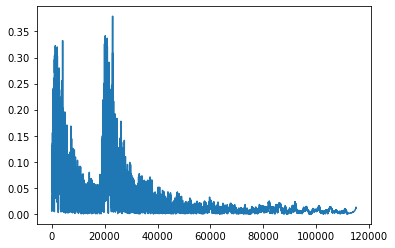

In [7]:
hil = np.abs(scipy.signal.hilbert(test_y))
plt.plot(hil)

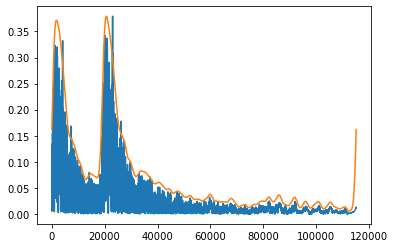

In [8]:
# filter the hilbert transform and make sure things look okay
hilk = np.fft.fft(hil)
hilk *= np.exp(-k*k / (2*10**2))
hil2 = np.fft.ifft(hilk)
hil2 = np.abs(hil2)
hil2 *= hil.max() / hil2.max()
plt.plot(hil)
plt.plot(np.abs(hil2))

In [9]:
# filtered hilbert scaling
testwav2 = test_y * hil2/np.sqrt((test_y*test_y).mean())
testwav2 *= test_y.max() / testwav2.max()

To ensure that our cleaning here hasn't been catastrophic we listen to the audio files. Without filtering of the hilbert transform there is noticable distortion in the signal.

In [10]:
# Unadulterated audio signal
IPython.display.Audio(test_y / test_y.max(),rate=sr)

In [11]:
# Scaling by unfiltered hilbert transform
IPython.display.Audio(testwav / testwav.max() * test_y.max(),rate=sr)

In [12]:
# Scaling by filtered hilbert tranform
IPython.display.Audio(testwav2 / testwav2.max() * test_y.max(),rate=sr)

We now generate the equilizer values by manually summing over the relevent portions of fourier space. Here we do this with each of the 3 signals to see how our cleaning step is affecting the results

In [13]:
eq_cutoffs = [20.0, 40.0, 80.0, 160.0, 300.0, 600.0, 1200.0, 2400.0, 5000.0, 10000.0, 20000.0, np.inf]
equilizer = np.zeros(12)
equilizer2 = np.zeros(12)
equilizer3 = np.zeros(12)

ykclean = np.fft.fft(testwav)
mag_ykclean = np.abs(ykclean)
mag_ykclean = mag_ykclean[:len(mag_ykclean)//2]

ykclean2 = np.fft.fft(testwav2)
mag_ykclean2 = np.abs(ykclean2)
mag_ykclean2 = mag_ykclean2[:len(mag_ykclean2)//2]

index = 0
for i in range(0,12):
    num = 0
    while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
        equilizer[i] += mag_yk[index]
        equilizer2[i] += mag_ykclean[index]
        equilizer3[i] += mag_ykclean2[index]
        index += 1
        num += 1
    equilizer[i] /= num
    equilizer2[i] /= num
    equilizer3[i] /= num
    
equilizer /= equilizer.max()
equilizer2 /= equilizer2.max()
equilizer3 /= equilizer3.max()

In [14]:
print(equilizer)
print(equilizer2)
print(equilizer3)

[0.7346875  1.         0.7766004  0.53614021 0.37440668 0.32556507
 0.23651321 0.13944434 0.08363195 0.04882461 0.0251458  0.02284873]
[0.64105894 1.         0.80952242 0.59104958 0.44453732 0.38825493
 0.28387851 0.16895286 0.10413631 0.0619349  0.03204841 0.02912976]
[0.69964721 1.         0.74162181 0.50426083 0.34569131 0.28882308
 0.20580009 0.12123321 0.07385924 0.04345445 0.02242813 0.02038173]


Sanity check with some plots. We notice that the unfiltered version of our clean up step displays distortion in the numerical data as well as testing by ear.

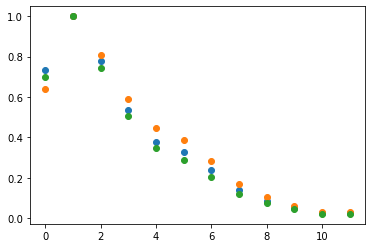

In [15]:
plt.scatter(range(0,12),equilizer)
plt.scatter(range(0,12),equilizer2)
plt.scatter(range(0,12),equilizer3)

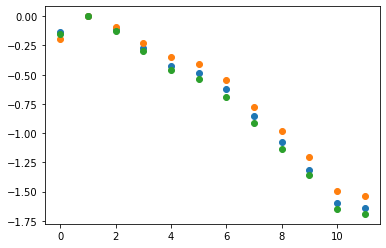

In [16]:
plt.scatter(range(0,12),np.log(equilizer)/np.log(10.0))
plt.scatter(range(0,12),np.log(equilizer2)/np.log(10.0))
plt.scatter(range(0,12),np.log(equilizer3)/np.log(10.0))

We have been iterating through feature selection, and fitting, and examination of the confusion matrix shows that
1. The classifier stuggles to differentiate between music and other types of data.
2. Gun shots and children playing are often paired in the confusion matrix.

We expect that children playing should be a much more "musical" type of sound than gun shots. For these two reasons we are going to try and extract some music based features.

Librosa has a function to decompose the harmonic and percussive components of a spectrogram. This seems to be done by checking for peaks in the fourier domain (harmonic) and time domain (percussive).

In [17]:
D = librosa.stft(testwav2 / testwav2.max())
y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)

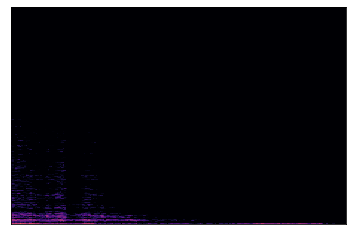

In [18]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(y_harmonic),ref=np.max))

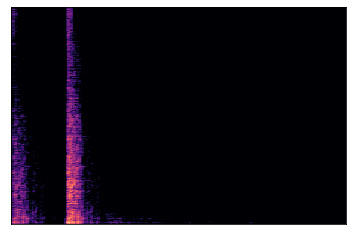

In [19]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(y_percussive),ref=np.max))

The decomposition loses a certain amount of power based on the 'margin' command which essentially sets how harsh the decomposition should be. For this reason we are going to rescale the power such that the sum of the two components still holds the same level of total power.

0.9999999999999999 0.8841165049763627 0.11588349502363711 0.9999999999999999


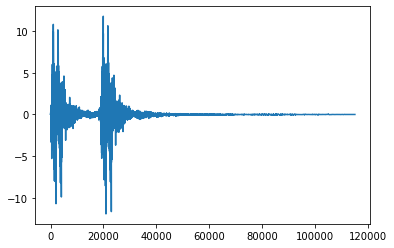

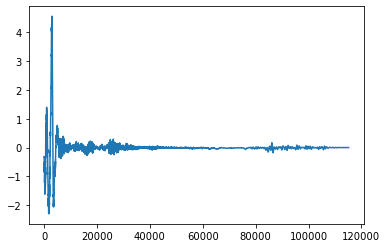

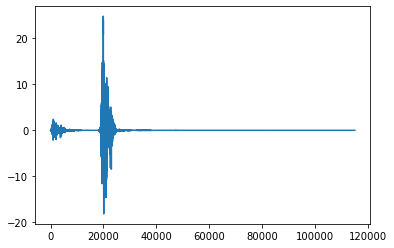

<Figure size 432x288 with 0 Axes>

In [20]:
D = librosa.stft(testwav2 / testwav2.max())
y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)
y_p = librosa.istft(y_percussive, length=len(testwav2))
y_h = librosa.istft(y_harmonic, length=len(testwav2))
Ptot = (testwav2**2).mean()
ynorm = testwav2 / np.sqrt(Ptot)
Pnorm = (ynorm**2).mean()
P_p = (y_p**2).mean()
P_h = (y_h**2).mean()
Anorm = np.sqrt(Pnorm/(P_h+P_p))
y_p *= Anorm
y_h *= Anorm
P_p = (y_p**2).mean()
P_h = (y_h**2).mean()

print(Pnorm, P_p, P_h, (P_h + P_p))
plt.figure()
plt.plot(ynorm)
plt.figure()
plt.plot(y_h)
plt.figure()
plt.plot(y_p)
plt.figure()

y_percussive = librosa.stft(y_p)
y_harmonic = librosa.stft(y_h)

From the harmonic component we are going to generate a measure of the harmonics within the sound wave. A great deal of music is made up of chords from major thirds, minor thirds, major fifths, and a triplet consisting of a base frequency with its major third and major fifth.

The first thing we are going to do is extract the mean power in the various frequencies corresponding to different MIDI keys. MIDI keys are essentially just integer numbers corresponding to the frequencies produced keys on a piano tuned using equal temperament. The equation for the central frequency of each MIDI index is

\begin{equation}
    F_\mathrm{pitch}(p) = 2^{(p-69)/12} 440 \;\mathrm{Hz}.
\end{equation}

The bandwidth of the MIDI frequency then ranges from $p-0.5$ to $p+0.5$.

A major third is then a pair consisting of a base frequency (MIDI $n$) and the key whose central frequency is closest to $3 f_n /2$. In a MIDI keyboard this then is the pair (MIDI $n$)+(MIDI $n+4$). Similarly minor thirds are (MIDI $n$)+(MIDI $n+3$), and major fifths are (MIDI $n$)+(MIDI $n+7$).

67


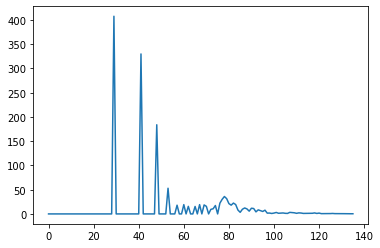

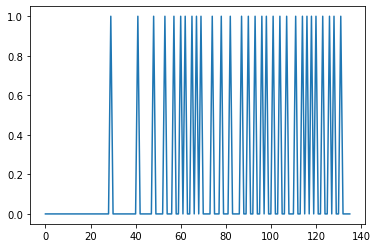

In [21]:
st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
fbins = []
keypitch = []
midi = []
maxlen=np.size(y_harmonic,0)
p = -69
kmin = 440*2**((p - 0.5)/12)
kmax = 440*2**((p+0.5)/12)
while kmax <= 20000:
    kmin = 440*2**((p - 0.5)/12)
    kmax = 440*2**((p+0.5)/12)
    if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),0])) != 0) :
        sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),0]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),0]))
    else:
        sumbin = 0
    fbins.append(sumbin)
    keypitch.append(440*2**(p/12))
    midi.append(p+69)
    p += 1
print(p)
plt.figure()
plt.plot(midi, fbins)
len(librosa.util.peak_pick(np.asarray(fbins), pre_max=1, post_max=1, pre_avg=1, post_avg=1, delta=0, wait=0))
peaks = librosa.util.localmax(np.asarray(fbins))
plt.figure()
plt.plot(np.asarray(peaks))

there are  0  major third(s),  0  minor third(s),  1  major third(s), and  0  major chord(s).


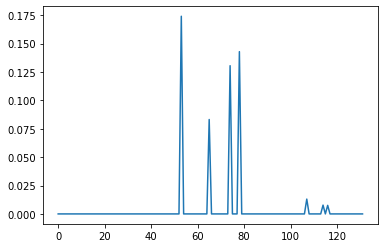

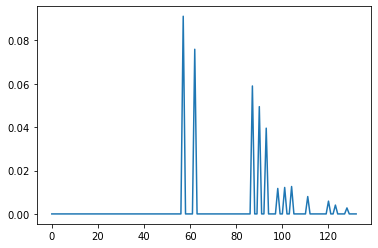

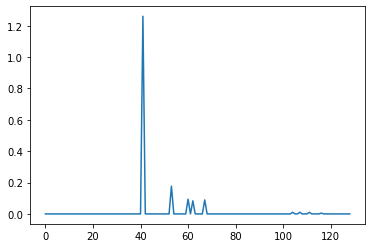

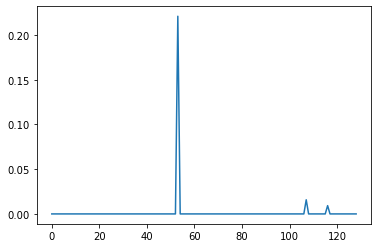

In [22]:
maj3 = []
min3 = []
maj5 = []
majchord = []
fbins = np.asarray(fbins)
favg = fbins[fbins > 0].max()
for i in range(len(fbins)-4):
    maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
for i in range(len(fbins)-3):
    min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
for i in range(len(fbins)-7):
    maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
    majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


maj3 = np.asarray(maj3)
min3 = np.asarray(min3)
maj5 = np.asarray(maj5)
majchord = np.asarray(majchord)
harmonicality  = len(maj3[np.log10(maj3+1e-12)>=-0.5]) + len(min3[np.log10(min3+1e-12)>=-0.5])+len(maj5[np.log10(maj5+1e-12)>=-0.5])+len(majchord[np.log10(majchord+1e-12)>=-0.5])
print("there are ",len(maj3[np.log10(maj3+1e-12)>=-0.5])," major third(s), ",
      len(min3[np.log10(min3+1e-12)>=-0.5])," minor third(s), ",
      len(maj5[np.log10(maj5+1e-12)>=-0.5])," major third(s), and ",
      len(majchord[np.log10(majchord+1e-12)>=-0.5])," major chord(s).")

plt.figure()
plt.plot((np.asarray(maj3) +1e-9))
plt.figure()
plt.plot((np.asarray(min3) +1e-9))
plt.figure()
plt.plot((np.asarray(maj5) +1e-9))
plt.figure()
plt.plot((np.asarray(majchord) +1e-9))

We also want to recognize the percussive hits. This is easy enough to do using the librosa onset_strength function. We then use peak detection to generate the total number of percussive crashes in the soundwave.

percussive peaks are at  [ 3 38] for a total length of  2


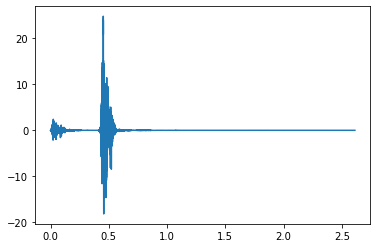

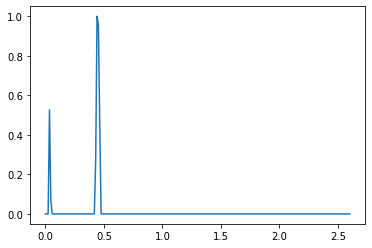

In [23]:
y_out = librosa.istft(y_percussive, length=len(test_y))
times = librosa.times_like(y_percussive)
plt.plot(dt*range(len(y_out)),y_out)
onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
#                                           hop_length=512,
                                         max_size=5,
                                          aggregate=np.median)
plt.figure()
plt.plot(times/2, onset_env / onset_env.max())
perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)
# onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
# onset_frames = librosa.onset.onset_detect(y = y_out, sr=sr)

print("percussive peaks are at ", perc_peaks, "for a total length of ", len(perc_peaks))

Make a function to do the cleanup and save the results as a nice, compact csv file.

We have iterated on the features a number of times, as can be seen by the commented out headers. In this version we include salience (whether the sound is background or foreground), as well as the power in the percussive and harmonic parts, and the number of percussive hits, and the time averaged number of harmonic chords.

Salience is ultimately removed in the classification notebooks, but there is little reason to regenerate the csv files.

In [36]:
def make_csv(filenm):
    file = open(filenm,'w+')
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,fold\n")
#     file.write("class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,thirds,fifths,fold\n")
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,musicality,fold\n")
    file.write("class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold\n")


#     eq_cutoffs = [20.0, 40.0, 80.0, 160.0, 300.0, 600.0, 1200.0, 2400.0, 5000.0, 10000.0, 20000.0, np.inf]
    eq_cutoffs = [10.0, 20.0, 30.0, 40.0, 60.0, 80.0, 120.0, 160.0, 230.0, 300.0, 450.0, 600.0, 900.0, 1200.0, 1800.0, 2400.0, 3700.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0, np.inf]


    for row_ind in range(0,len(metadata)):
        ## load in the data
        row = metadata.loc[row_ind]
        y,sr = load_data(metadata.loc[row_ind])
        ## get the class and fold
        classifier = metadata['class'][row_ind]
        foldinfo = metadata['fold'][row_ind]
        ## get timing info
        t = round(row["end"]-row["start"],3)
        dt = t/len(y)
        k = np.fft.fftfreq(len(y), d=dt)
#         k = k[:len(k)//2]
        ## get salience
        sal = row["salience"]
        
        
        ## hilbert transform filtering for "room noise"
        hil = np.abs(scipy.signal.hilbert(y))
        hilk = np.fft.fft(hil)
        hilk *= np.exp(-k*k / (2*10**2))
        hil2 = np.fft.ifft(hilk)
        hil2 = np.abs(hil2)
        hil2 *= hil.max() / hil2.max()
        filt_y = y * hil2/np.sqrt((y*y).mean())
        filt_y *= y.max() / filt_y.max()
        y_sq = filt_y*filt_y
        ## get crest factor
        Cr = filt_y.max() / np.sqrt(y_sq.mean())
        
        yk = np.fft.fft(filt_y)
        mag_yk = np.abs(yk)
        mag_yk = mag_yk[:len(mag_yk)//2]
        
        ## seperate into harmonic and percussive components
        D = librosa.stft(filt_y / filt_y.max())
        y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)
        y_p = librosa.istft(y_percussive, length=len(filt_y))
        y_h = librosa.istft(y_harmonic, length=len(filt_y))
        Ptot = (filt_y**2).mean()
        ynorm = filt_y / np.sqrt(Ptot)
        Pnorm = (ynorm**2).mean()
        P_p = (y_p**2).mean()
        P_h = (y_h**2).mean()
        Anorm = np.sqrt(Pnorm/(P_h+P_p))
        y_p *= Anorm
        y_h *= Anorm
        
        y_percussive = librosa.stft(y_p)
        y_harmonic = librosa.stft(y_h)
        
        ## generate the MIDI range and corresponding frequencies
        st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
        fbins = []
        keypitch = []
        midi = []
        maxlen=np.size(y_harmonic,0)
        p = -69
        kmin = 440*2**((p - 0.5)/12)
        kmax = 440*2**((p+0.5)/12)
        while kmax <= 20000:
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)
            keypitch.append(440*2**(p/12))
            midi.append(p+69)
            p += 1
            
        ## sum up the number of 3rds, 5ths, and chords
        harmonicality = 0
        for tm in range(np.size(y_harmonic,1)):
            p = -69
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)    
            while kmax <= 20000:
                kmin = 440*2**((p - 0.5)/12)
                kmax = 440*2**((p+0.5)/12)
                if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm])) != 0) :
                    sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]))
                else:
                    sumbin = 0
                fbins.append(sumbin)
                p += 1

            peaks = librosa.util.localmax(np.asarray(fbins))

            maj3 = []
            min3 = []
            maj5 = []
            majchord = []
            fbins2 = np.asarray(fbins)
            if len(fbins2[fbins2 > 0] > 0):
                favg = fbins2[fbins2 > 0].max()
            else:
                favg = 1
            for i in range(len(fbins)-4):
                maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
            for i in range(len(fbins)-3):
                min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
            for i in range(len(fbins)-7):
                maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
                majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


            maj3 = np.asarray(maj3)
            min3 = np.asarray(min3)
            maj5 = np.asarray(maj5)
            majchord = np.asarray(majchord)
            maj3 = len(maj3[np.log10(maj3 + 1e-12)>=-0.5])
            min3 = len(min3[np.log10(min3 + 1e-12)>=-0.5])
            maj5 = len(maj5[np.log10(maj5 + 1e-12)>=-0.5])
            majchord = len(majchord[np.log10(majchord + 1e-12)>=-0.5])
            harmonicality += maj3 + min3 + maj5 + majchord
        
        ## divide by the number of time slices to get mean harmonicality
        harmrate = harmonicality / np.size(y_harmonic,1)
        
        
        ## from the percussive component get the onsets for number of percussive hits
        y_out = librosa.istft(y_percussive, length=len(filt_y))

        onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
                                                 max_size=5,
                                                  aggregate=np.median)

        perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)


        perc_rate = len(perc_peaks) #/ t
        
        ## generate equilizer values from fourier transform
        equilizer = np.zeros(len(eq_cutoffs))
        index = 0
        for i in range(len(equilizer)):
            num = 0
            while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
                equilizer[i] += mag_yk[index]
                index += 1
                num += 1
            equilizer[i] /= num
            
        ## write everything to csv
        file.write(classifier)
        for i in range(len(eq_cutoffs)):
            file.write(","+str(equilizer[i]))
        
        file.write(","+str(Cr))
        file.write(","+str(sal))
        file.write(","+str(P_h))
        file.write(","+str(P_p))
        file.write(","+str(harmrate))
        file.write(","+str(perc_rate))
        file.write(","+str(foldinfo)+"\n")
        print("preprocessed audio file ", str(row_ind))
    file.close()

This preprocessing takes a rather long period of time. For this reason, we choose not to run it locally within the jupyter notebook, but to delegate it to a small workstation of 20 dual threaded processors, parallelized using the jobslib library in python.

In [ ]:
make_csv('./large_data/eq_with_harmony3.csv')

preprocessed audio file  0
preprocessed audio file  1
preprocessed audio file  2
preprocessed audio file  3
preprocessed audio file  4
preprocessed audio file  5
preprocessed audio file  6
preprocessed audio file  7
preprocessed audio file  8
preprocessed audio file  9
preprocessed audio file  10
preprocessed audio file  11
preprocessed audio file  12
preprocessed audio file  13
preprocessed audio file  14
preprocessed audio file  15
preprocessed audio file  16
preprocessed audio file  17
preprocessed audio file  18
preprocessed audio file  19
preprocessed audio file  20
preprocessed audio file  21
preprocessed audio file  22
preprocessed audio file  23
preprocessed audio file  24
preprocessed audio file  25
preprocessed audio file  26
preprocessed audio file  27
preprocessed audio file  28
preprocessed audio file  29
preprocessed audio file  30
preprocessed audio file  31
preprocessed audio file  32
preprocessed audio file  33
preprocessed audio file  34
preprocessed audio file  35
pr

While this is not run within the notebook, and the raw .py file will be included in the github, for the sake of completeness we include the parallelized code in the cleaning.py file here as well.

# Parallelized functions for the cleaning loops

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display
import os

import scipy
from joblib import Parallel, delayed

# Data should be placed in the "large_data/" directory, which is not staged in the git repo
metadata = pd.read_csv('./large_data/UrbanSound8K/metadata/UrbanSound8K.csv')
# metadata.info()

# Function to load wav file with librosa, given a row from metadata table
def load_data(meta_row):
    filename = meta_row['slice_file_name']
    filepath = f'large_data/UrbanSound8K/audio/fold{meta_row["fold"]}/'
    return librosa.load(filepath+filename,sr=None)


def write_csv_line(filenm, eq_cutoffs, row_ind):
    file = open(filenm+"_"+str(os.getpid())+".csv",'a+')
    row = metadata.loc[row_ind]
    y,sr = load_data(metadata.loc[row_ind])
    ## get the class and fold
    classifier = metadata['class'][row_ind]
    foldinfo = metadata['fold'][row_ind]
    ## get timing info
    t = round(row["end"]-row["start"],3)
    dt = t/len(y)
    k = np.fft.fftfreq(len(y), d=dt)
#         k = k[:len(k)//2]
    ## get salience
    sal = row["salience"]


    ## hilbert transform filtering for "room noise"
    hil = np.abs(scipy.signal.hilbert(y))
    hilk = np.fft.fft(hil)
    hilk *= np.exp(-k*k / (2*10**2))
    hil2 = np.fft.ifft(hilk)
    hil2 = np.abs(hil2)
    hil2 *= hil.max() / hil2.max()
    filt_y = y * hil2/np.sqrt((y*y).mean())
    filt_y *= y.max() / filt_y.max()
    y_sq = filt_y*filt_y
    ## get crest factor
    Cr = filt_y.max() / np.sqrt(y_sq.mean())

    yk = np.fft.fft(filt_y)
    mag_yk = np.abs(yk)
    mag_yk = mag_yk[:len(mag_yk)//2]

    ## seperate into harmonic and percussive components
    D = librosa.stft(filt_y / filt_y.max())
    y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)
    y_p = librosa.istft(y_percussive, length=len(filt_y))
    y_h = librosa.istft(y_harmonic, length=len(filt_y))
    Ptot = (filt_y**2).mean()
    ynorm = filt_y / np.sqrt(Ptot)
    Pnorm = (ynorm**2).mean()
    P_p = (y_p**2).mean()
    P_h = (y_h**2).mean()
    Anorm = np.sqrt(Pnorm/(P_h+P_p))
    y_p *= Anorm
    y_h *= Anorm

    y_percussive = librosa.stft(y_p)
    y_harmonic = librosa.stft(y_h)

    ## generate the MIDI range and corresponding frequencies
    st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
    fbins = []
    keypitch = []
    midi = []
    maxlen=np.size(y_harmonic,0)
    p = -69
    kmin = 440*2**((p - 0.5)/12)
    kmax = 440*2**((p+0.5)/12)
    while kmax <= 20000:
        kmin = 440*2**((p - 0.5)/12)
        kmax = 440*2**((p+0.5)/12)
        keypitch.append(440*2**(p/12))
        midi.append(p+69)
        p += 1

    ## sum up the number of 3rds, 5ths, and chords
    harmonicality = 0
    for tm in range(np.size(y_harmonic,1)):
        p = -69
        kmin = 440*2**((p - 0.5)/12)
        kmax = 440*2**((p+0.5)/12)
        while kmax <= 20000:
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)
            if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm])) != 0) :
                sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]))
            else:
                sumbin = 0
            fbins.append(sumbin)
            p += 1

        peaks = librosa.util.localmax(np.asarray(fbins))

        maj3 = []
        min3 = []
        maj5 = []
        majchord = []
        fbins2 = np.asarray(fbins)
        if len(fbins2[fbins2 > 0] > 0):
            favg = fbins2[fbins2 > 0].max()
        else:
            favg = 1
        for i in range(len(fbins)-4):
            maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
        for i in range(len(fbins)-3):
            min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
        for i in range(len(fbins)-7):
            maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
            majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


        maj3 = np.asarray(maj3)
        min3 = np.asarray(min3)
        maj5 = np.asarray(maj5)
        majchord = np.asarray(majchord)
        maj3 = len(maj3[np.log10(maj3 + 1e-12)>=-0.5])
        min3 = len(min3[np.log10(min3 + 1e-12)>=-0.5])
        maj5 = len(maj5[np.log10(maj5 + 1e-12)>=-0.5])
        majchord = len(majchord[np.log10(majchord + 1e-12)>=-0.5])
        harmonicality += maj3 + min3 + maj5 + majchord

    ## divide by the number of time slices to get mean harmonicality
    harmrate = harmonicality / np.size(y_harmonic,1)


    ## from the percussive component get the onsets for number of percussive hits
    y_out = librosa.istft(y_percussive, length=len(filt_y))

    onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
                                             max_size=5,
                                              aggregate=np.median)

    perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)


    perc_rate = len(perc_peaks) #/ t

    ## generate equilizer values from fourier transform
    equilizer = np.zeros(len(eq_cutoffs))
    index = 0
    for i in range(len(equilizer)):
        num = 0
        while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
            equilizer[i] += mag_yk[index]
            index += 1
            num += 1
        equilizer[i] /= num

    ## write everything to csv
    file.write(str(row_ind)+",")
    file.write(classifier)
    for i in range(len(eq_cutoffs)):
        file.write(","+str(equilizer[i]))

    file.write(","+str(Cr)+","+str(sal)+","+str(P_h)+","+str(P_p)+","+str(harmrate)+","+str(perc_rate)+","+str(foldinfo)+"\n")
    # file.write(","+str(sal))
    # file.write(","+str(P_h))
    # file.write(","+str(P_p))
    # file.write(","+str(harmrate))
    # file.write(","+str(perc_rate))
    # file.write(","+str(foldinfo)+"\n")
    print("preprocessed audio file ", str(row_ind))
    file.close()


def make_csv(filenm):
    file = open(filenm+"_header.csv",'a+')
    file.write("index,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold\n")
    file.close()

    eq_cutoffs = [10.0, 20.0, 30.0, 40.0, 60.0, 80.0, 120.0, 160.0, 230.0, 300.0, 450.0, 600.0, 900.0, 1200.0, 1800.0, 2400.0, 3700.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0, np.inf]

    backend = 'loky'

    Parallel(n_jobs=40, backend = backend)(delayed(write_csv_line)(filenm, eq_cutoffs, row_ind) for row_ind in range(len(metadata)))

make_csv('./large_data/eq_with_harmony3')
